# Data Preprocessing


### Libarary and Imports

In [ ]:
# Load Libraries
import pandas as pd
import numpy as np
from gensim.utils import simple_preprocess
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn import preprocessing
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# read data
from google.colab import drive
drive.mount('/content/drive')
# Daniel's
train = pd.read_csv("/content/train.csv")
pet_predict = pd.read_csv("/content/comparison_results.csv")
#breeds_labels = pd.read_csv("/content/breed_labels.csv")

Mounted at /content/drive


In [ ]:
# get a summary of data
pet_predict

,PetID,AdoptionStatus,PredictedAdoptionSpeed
0,3e3743dc7,0,0
1,cb05f298c,0,0
2,69d95bc54,1,1
3,ff9f62e79,1,1
4,4a1274da0,1,1
...,...,...,...
13338,727a1c793,0,0
13339,6c9e1c82f,1,1
13340,9718baba0,1,0
13341,a0c332aaf,1,0


## Machine Learning Models


## Feature Engineering

### Age * Type Interaction

In [ ]:
train['age_type_interaction'] = train['Age'] * train['Type']

### Changing 'AdoptionSpeed' to Binary

In [ ]:
# Assign 0 to "Not Adopted" and 1 to "Adopted"
train['AdoptionStatus'] = train['AdoptionSpeed'].apply(lambda x: 0 if x == 4 else 1)

# Separate samples for each label within the "Adopted" class
adopted_label_1 = train[train['AdoptionSpeed'] == 1]
adopted_label_2 = train[train['AdoptionSpeed'] == 2]
adopted_label_3 = train[train['AdoptionSpeed'] == 3]
adopted_label_4 = train[train['AdoptionSpeed'] == 4]

# Sample an equal number of "Not Adopted" samples for each label within the "Adopted" class
not_adopted_samples = train[train['AdoptionStatus'] == 0]
adopted_downsampled_label_1 = resample(adopted_label_1,
                                       replace=False,
                                       n_samples=len(adopted_label_1),
                                       random_state=42)
adopted_downsampled_label_2 = resample(adopted_label_2,
                                       replace=False,
                                       n_samples=len(adopted_label_2),
                                       random_state=42)
adopted_downsampled_label_3 = resample(adopted_label_3,
                                       replace=False,
                                       n_samples=len(adopted_label_3),
                                       random_state=42)
adopted_downsampled_label_4 = resample(adopted_label_4,
                                       replace=False,
                                       n_samples=len(adopted_label_4),
                                       random_state=42)

# Concatenate the downsampled adopted samples with the not adopted samples
balanced_df = pd.concat([adopted_downsampled_label_1,
                         adopted_downsampled_label_2,
                         adopted_downsampled_label_3,
                         adopted_downsampled_label_4,
                         not_adopted_samples])

# Shuffle the dataset
train = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
train

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,age_type_interaction,AdoptionStatus
0,1,Panda,30,205,0,2,7,0,0,1,...,500,41326,eef145eefa54d9f08c44217170f9560a,0,Panda is a rare Shih Tzu breed that I adopted ...,b7351540f,5.0,3,30,1
1,1,Creamy,72,109,0,2,3,5,0,3,...,0,41326,3b074cadd2350de62dca7056b9bab6f4,0,FOR serious adopters only! Requirements for Ad...,1751240fe,0.0,4,72,0
2,2,NaN,12,299,0,1,3,4,0,2,...,0,41326,d8af7afece71334473575c9f70daf00d,0,"Found at Astaka Field, Pj on 28 May . Will be ...",d1938a57f,1.0,1,24,1
3,2,Rio,8,266,0,1,1,7,0,2,...,0,41326,b9ee99b79d382106af36eba5d362c364,0,He's a very playful and loyal cat. Can be a ve...,b13db9ce8,4.0,1,16,1
4,2,NaN,24,266,299,2,1,2,6,2,...,160,41326,2a6ced77b804df242172dbcc444394d6,0,very active and playful personality cat. atten...,4dd89c859,1.0,4,48,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18775,2,Meme,12,266,266,2,1,7,0,2,...,180,41401,27083c7f0a040994ca84395f4b17d80b,0,Meme is a very friendly and well behave cat~ M...,ee63ca0b4,2.0,4,24,0
18776,2,Sudu,7,299,0,1,1,6,7,1,...,100,41326,525435aafa7bf23c9118850d388ff80c,0,"Sudu is sweet, petite loving tabby boy who was...",00eca0391,5.0,4,14,0
18777,1,Bailey,2,307,0,1,2,0,0,2,...,0,41326,7a22a977b447e38f94017409294d1932,0,"Hello, my name is Bailey and I'm a mongrel. I'...",e1d40ecc1,1.0,2,2,1
18778,1,Jack Russell Terier For Adoption!,1,128,129,3,1,2,7,1,...,0,41401,eaaf22c28570200164914648fdbb9e2e,0,These are the children of a female Jack Russel...,fa1d3af33,2.0,1,1,1


In [ ]:
print(train['AdoptionStatus'].value_counts())

AdoptionStatus
1    10386
0     8394
Name: count, dtype: int64


AdoptionStatus
1    10386
0     8394
Name: count, dtype: int64


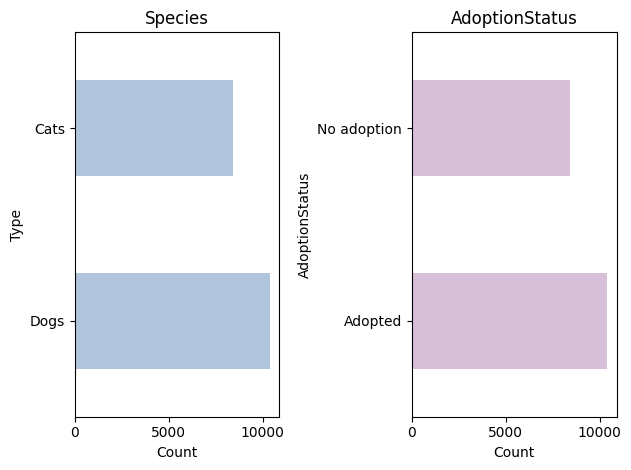

In [ ]:
# display species graph
plt.subplot(1, 2, 1)
train['Type'].value_counts().rename({1:'Dogs',2:'Cats'}).plot(kind='barh',color='lightsteelblue')
plt.title('Species')
plt.xlabel('Count')

# display adoption speed graph
plt.subplot(1, 2, 2)
train['AdoptionStatus'].value_counts().rename(
    {0:'No adoption',
     1:'Adopted'}).plot(kind='barh', color='thistle')
plt.title('AdoptionStatus')
plt.xlabel('Count')
print(train['AdoptionStatus'].value_counts())

# minimize overlap
plt.tight_layout()

### Preprocessing 'Description' Variable

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in
                    lst_stopwords]

    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    text = " ".join(lst_text)
    return text

lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
train["Description"] = train["Description"].apply(lambda x:
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True,
          lst_stopwords=lst_stopwords))

train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,age_type_interaction,AdoptionStatus
0,1,Panda,30,205,0,2,7,0,0,1,...,500,41326,eef145eefa54d9f08c44217170f9560a,0,panda rare shih tzu breed adopted 2years ago h...,b7351540f,5.0,3,30,1
1,1,Creamy,72,109,0,2,3,5,0,3,...,0,41326,3b074cadd2350de62dca7056b9bab6f4,0,serious adopter requirement adoption adoption ...,1751240fe,0.0,4,72,0
2,2,NaN,12,299,0,1,3,4,0,2,...,0,41326,d8af7afece71334473575c9f70daf00d,0,found astaka field pj 28 may put adoption clai...,d1938a57f,1.0,1,24,1
3,2,Rio,8,266,0,1,1,7,0,2,...,0,41326,b9ee99b79d382106af36eba5d362c364,0,he playful loyal cat good companion home frien...,b13db9ce8,4.0,1,16,1
4,2,NaN,24,266,299,2,1,2,6,2,...,160,41326,2a6ced77b804df242172dbcc444394d6,0,active playful personality cat attention seeki...,4dd89c859,1.0,4,48,0


In [ ]:
def count_words(text):
    return len(text.split())
train['Word_Count'] = train['Description'].apply(lambda x: count_words(x))
print(train.head())

   Type    Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     1   Panda   30     205       0       2       7       0       0   
1     1  Creamy   72     109       0       2       3       5       0   
2     2     NaN   12     299       0       1       3       4       0   
3     2     Rio    8     266       0       1       1       7       0   
4     2     NaN   24     266     299       2       1       2       6   

   MaturitySize  ...  State                         RescuerID  VideoAmt  \
0             1  ...  41326  eef145eefa54d9f08c44217170f9560a         0   
1             3  ...  41326  3b074cadd2350de62dca7056b9bab6f4         0   
2             2  ...  41326  d8af7afece71334473575c9f70daf00d         0   
3             2  ...  41326  b9ee99b79d382106af36eba5d362c364         0   
4             2  ...  41326  2a6ced77b804df242172dbcc444394d6         0   

                                         Description      PetID  PhotoAmt  \
0  panda rare shih tzu breed adopted 2y

In [ ]:
# Finding the distribution of word_count
#statistics = train['Word_Count'].describe()
#print(statistics)

### Word2Vec

In [ ]:
#from gensim.models import Word2Vec

# Train a Word2Vec model
#model = Word2Vec(sentences=train['Description'], vector_size=100, window=5, min_count=2, workers=4)

# Save the model for later use
#model.save("Word2Vec.model")

# Pad or truncate word vectors to ensure consistency
#word_vectors_padded = pad_sequences(word_vectors, maxlen=35, dtype='float32', padding='post')

#train['word2vec_features'] = word_vectors_padded.tolist()

In [ ]:
# Function to convert a document to a vector
#def document_to_vec(words, model):
    # Remove out-of-vocabulary words
#    words = [word for word in words if word in model.wv.key_to_index]
#    if len(words) >= 1:
#        return np.mean(model.wv[words], axis=0)
#    else:
#        return []

# Vectorize each description
#train['vec'] = train['Description'].apply(lambda x: document_to_vec(x, model))


In [ ]:
# Assuming all vectors are of the same length, for example, 100 dimensions
#vectorized_df = pd.DataFrame(train['vec'].tolist(), index=train.index)
#vectorized_df

In [ ]:
#train['average_vectors'] = vectorized_df.mean(axis=1)

In [ ]:
# Assuming you have other features stored in a DataFrame called `other_features_df`
# Concatenate the vectorized descriptions with the other features
# train = pd.concat([vectorized_df, train], axis=1)

In [ ]:
#train

### TextBlob

In [ ]:
from textblob import TextBlob

# Function to calculate sentiment polarity
def calculate_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

# Apply the function to your DataFrame
train['Description_Score'] = train['Description'].apply(calculate_sentiment)

# Quick look at the new column
print(train[['Description', 'Description_Score']].head())

                                         Description  Description_Score
0  panda rare shih tzu breed adopted 2years ago h...           0.085417
1  serious adopter requirement adoption adoption ...          -0.250000
2  found astaka field pj 28 may put adoption clai...           0.000000
3  he playful loyal cat good companion home frien...           0.469444
4  active playful personality cat attention seeki...          -0.133333


In [ ]:
train

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,age_type_interaction,AdoptionStatus,Word_Count,Description_Score
0,1,Panda,30,205,0,2,7,0,0,1,...,eef145eefa54d9f08c44217170f9560a,0,panda rare shih tzu breed adopted 2years ago h...,b7351540f,5.0,3,30,1,32,0.085417
1,1,Creamy,72,109,0,2,3,5,0,3,...,3b074cadd2350de62dca7056b9bab6f4,0,serious adopter requirement adoption adoption ...,1751240fe,0.0,4,72,0,16,-0.250000
2,2,NaN,12,299,0,1,3,4,0,2,...,d8af7afece71334473575c9f70daf00d,0,found astaka field pj 28 may put adoption clai...,d1938a57f,1.0,1,24,1,11,0.000000
3,2,Rio,8,266,0,1,1,7,0,2,...,b9ee99b79d382106af36eba5d362c364,0,he playful loyal cat good companion home frien...,b13db9ce8,4.0,1,16,1,10,0.469444
4,2,NaN,24,266,299,2,1,2,6,2,...,2a6ced77b804df242172dbcc444394d6,0,active playful personality cat attention seeki...,4dd89c859,1.0,4,48,0,18,-0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18775,2,Meme,12,266,266,2,1,7,0,2,...,27083c7f0a040994ca84395f4b17d80b,0,meme friendly well behave cat meme use stay gr...,ee63ca0b4,2.0,4,24,0,48,0.232955
18776,2,Sudu,7,299,0,1,1,6,7,1,...,525435aafa7bf23c9118850d388ff80c,0,sudu sweet petite loving tabby boy rescued pet...,00eca0391,5.0,4,14,0,20,0.312500
18777,1,Bailey,2,307,0,1,2,0,0,2,...,7a22a977b447e38f94017409294d1932,0,hello name bailey im mongrel ive rescued dog p...,e1d40ecc1,1.0,2,2,1,24,0.600000
18778,1,Jack Russell Terier For Adoption!,1,128,129,3,1,2,7,1,...,eaaf22c28570200164914648fdbb9e2e,0,child female jack russell terrier aunt rearthe...,fa1d3af33,2.0,1,1,1,21,0.366667


### Inserting deep learning predictions
(Put it here before splitting train and test because we need to use petID to match and merge the dataset)
(We will use this train_dl at the bottom part of the notebook)

In [ ]:
# prompt: how to drop AdoptionStatus column in train
pet_predict = pet_predict.drop(columns=['AdoptionStatus'])

In [ ]:
# Merge the prediction results with the train dataset based on 'petID'
train_dl = train.merge(pet_predict, on='PetID', how='left')

# Rename the 'AdoptionStatus_x' column to 'AdoptionStatus'
train_dl = train_dl.rename(columns={'AdoptionStatus_x': 'AdoptionStatus'})

In [ ]:
train_dl

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,age_type_interaction,AdoptionStatus,Word_Count,Description_Score,PredictedAdoptionSpeed
0,1,Panda,30,205,0,2,7,0,0,1,...,0,panda rare shih tzu breed adopted 2years ago h...,b7351540f,5.0,3,30,1,32,0.085417,1.0
1,1,Creamy,72,109,0,2,3,5,0,3,...,0,serious adopter requirement adoption adoption ...,1751240fe,0.0,4,72,0,16,-0.250000,NaN
2,2,NaN,12,299,0,1,3,4,0,2,...,0,found astaka field pj 28 may put adoption clai...,d1938a57f,1.0,1,24,1,11,0.000000,NaN
3,2,Rio,8,266,0,1,1,7,0,2,...,0,he playful loyal cat good companion home frien...,b13db9ce8,4.0,1,16,1,10,0.469444,1.0
4,2,NaN,24,266,299,2,1,2,6,2,...,0,active playful personality cat attention seeki...,4dd89c859,1.0,4,48,0,18,-0.133333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23359,2,Sudu,7,299,0,1,1,6,7,1,...,0,sudu sweet petite loving tabby boy rescued pet...,00eca0391,5.0,4,14,0,20,0.312500,0.0
23360,2,Sudu,7,299,0,1,1,6,7,1,...,0,sudu sweet petite loving tabby boy rescued pet...,00eca0391,5.0,4,14,0,20,0.312500,0.0
23361,1,Bailey,2,307,0,1,2,0,0,2,...,0,hello name bailey im mongrel ive rescued dog p...,e1d40ecc1,1.0,2,2,1,24,0.600000,0.0
23362,1,Jack Russell Terier For Adoption!,1,128,129,3,1,2,7,1,...,0,child female jack russell terrier aunt rearthe...,fa1d3af33,2.0,1,1,1,21,0.366667,NaN


### Splitting Train & Test

In [ ]:
train_dl = train_dl.dropna()

In [ ]:
drop = ['Name', 'Breed2', 'Color2','Color3', 'RescuerID', 'PetID', 'Description', 'AdoptionSpeed']
train_dl = train_dl.drop(drop, axis = 1)
X = train_dl.drop(['AdoptionStatus'], axis = 1)
y = train_dl.AdoptionStatus

#Train-Test Split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=0)

# confirm split
print('Training Features Shape:', Xtrain.shape)
print('Training Labels Shape:', ytrain.shape)
print('Testing Features Shape:', Xtest.shape)
print('Testing Labels Shape:', ytest.shape)

Training Features Shape: (15260, 20)
Training Labels Shape: (15260,)
Testing Features Shape: (3816, 20)
Testing Labels Shape: (3816,)


#### Based on the graph, it appears that the decision has been made to select 150 as the number of estimators (n_estimators) for the RandomForestClassifier. This choice seems to strike a balance between a good score and computational efficiency.

## Hyperparamter Tuning

### Hybrid Model (Using Deep Learning prediction as a covariate)

In [ ]:
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [120, 140, 150, 160],
    'max_features': [3, 4, 5, 'sqrt'],  # 'sqrt' corresponds to sqrt(n_features)
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Instantiate the grid search model with 10-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(Xtrain, ytrain)

# Get the best parameters found by grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model from the grid search
best_htrf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_htrf = best_htrf_model.predict(Xtest)

train_accuracy_htrf = best_htrf_model.score(Xtrain, ytrain)
test_accuracy_htrf = accuracy_score(ytest, y_pred_htrf)

# accuracy
print("Random Forest Hyperparameter tuned train accuracy: {:.2f}%".format(train_accuracy_htrf * 100))
print("Random Forest Hyperparameter tuned test accuracy: {:.2f}%".format(test_accuracy_htrf * 100))

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'bootstrap': True, 'max_depth': 160, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}
Random Forest Hyperparameter tuned train accuracy: 98.97%
Random Forest Hyperparameter tuned test accuracy: 87.58%


## Evaluation


#### Feature importances are typically computed as the average reduction in impurity that is brought by that feature across all the trees in the forest.

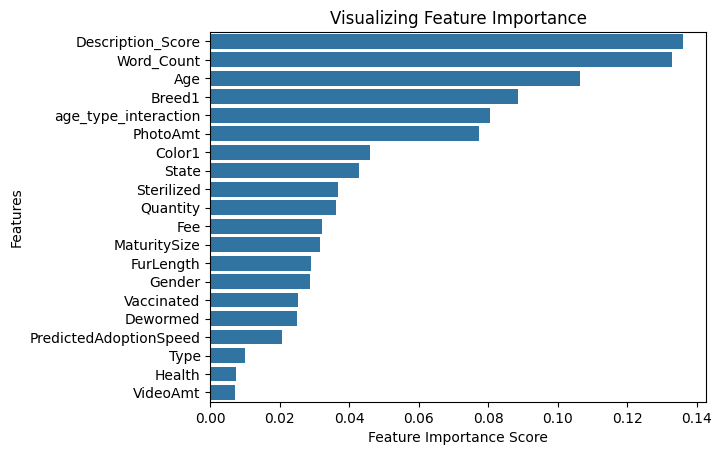

In [ ]:
feature_imp = pd.Series(best_htrf_model.feature_importances_,index=X.columns).sort_values(ascending=False) #creates a Series mapping each feature to its importance score as determined by the random forest model.
feature_imp
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Feature Importance")
plt.show()

### Top 5 features


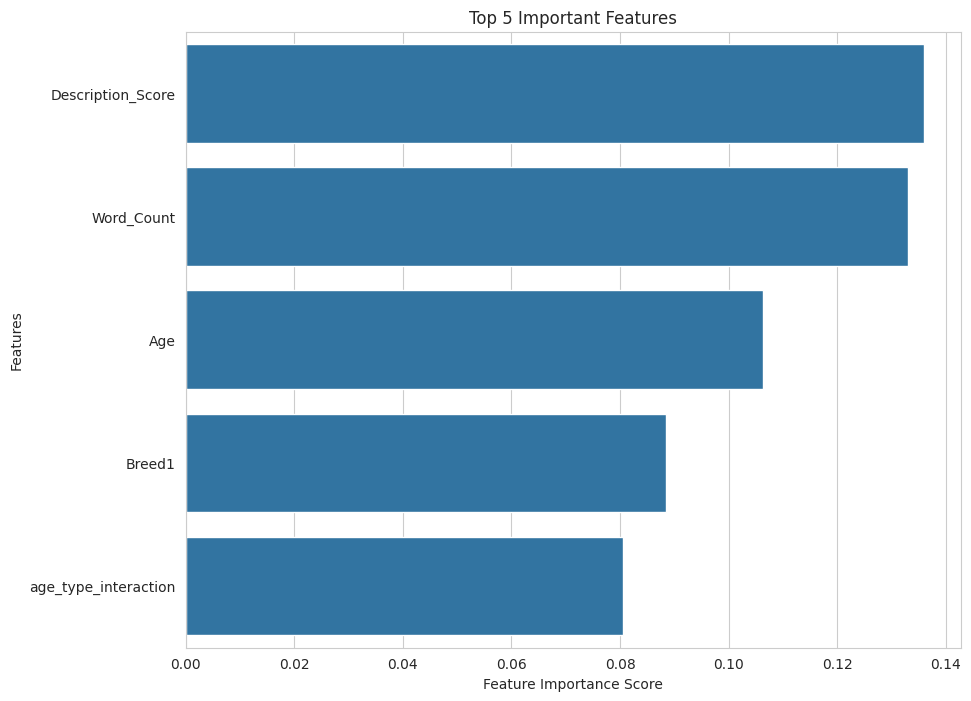

In [ ]:
top_10_features = feature_imp[:5]
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.barplot(x=top_10_features, y=top_10_features.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 5 Important Features")
plt.show()

### Performance Metrics

Due to the simplicity of the data, which used to be multi-class, the results could be due to trivial data (classification model was 78% testing accuracy)

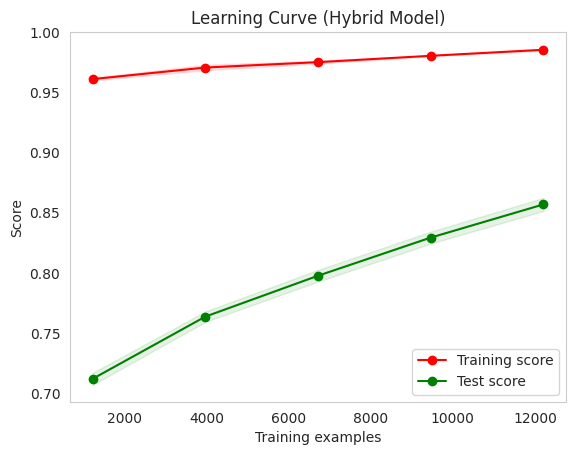

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

def plot_learning_curve(estimator, X_train, y_train, X_test, y_test, title=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    if title is not None:
        plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")

    plt.legend(loc="best")
    return plt


# Plot learning curve for hyperparameter tuned model
plot_learning_curve(best_htrf_model, Xtrain, ytrain, Xtest, y_pred_htrf, cv=5, title="Learning Curve (Hybrid Model)")
plt.show()

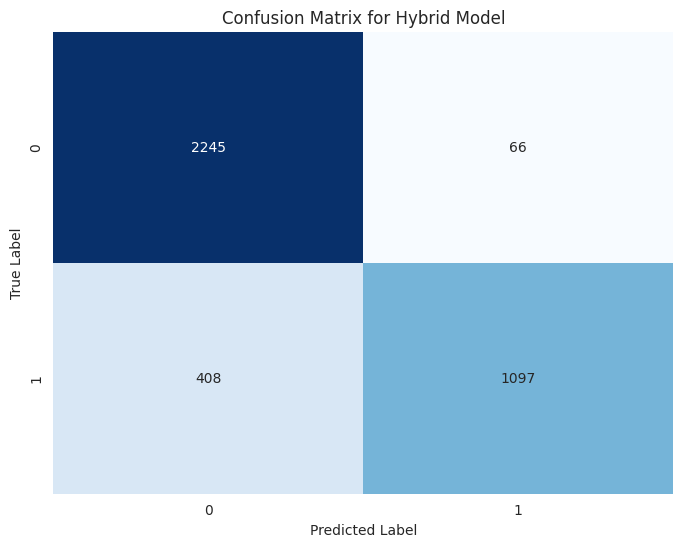

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(ytest, y_pred_htrf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Hybrid Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()